#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13912581089883723426
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3040277030671656708
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [6]:
data = pd.read_csv("data/data_gg.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [7]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [8]:
As = data
Cd = data
Ni = data

In [9]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [10]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(781, 16)
(781, 16)
(781, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [11]:
import smogn

In [12]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme', k = 3)
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme', k = 7)

r_index: 100%|##########| 91/91 [00:00<00:00, 558.16it/s]


In [13]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(1143, 16)
(1319, 16)
(1199, 16)


In [14]:
As_smogn = As_smogn.reset_index(drop = True)
Cd_smogn = Cd_smogn.reset_index(drop = True)
Ni_smogn = Ni_smogn.reset_index(drop = True)

#### Eliminate outlier and train / test split

In [15]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [16]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [17]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [18]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [19]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(982, 15)
(1269, 15)
(1136, 15)


StandardScaler

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [21]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '''

' from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nAs_X_scaled = scaler.fit_transform(As_X)\nCd_X_scaled = scaler.fit_transform(Cd_X)\nNi_X_scaled = scaler.fit_transform(Ni_X)\n\nAs_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)\nCd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)\nNi_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '

MinMaxScaler

In [22]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [23]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(785, 15)
(1015, 15)
(908, 15)


#### 10-Fold Crossvalidation

In [24]:
# kf = KFold(n_splits = 10, random_state = 42, shuffle = True)

#### Optuna Optimization

In [25]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [26]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR


def objectiveSVM(trial: Trial, X_train, y_train) -> float:
    C = trial.suggest_loguniform('C', 0.1, 100.0)
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    degree = trial.suggest_int('degree', 1, 5)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    model = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree)

    r2 = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)
    r2 = r2.mean()

    return r2


####  Optimization

In [27]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-30 16:50:07,152] A new study created in memory with name: svm_parameter_opt
[I 2023-08-30 16:50:07,315] Trial 0 finished with value: 0.4039748331857188 and parameters: {'C': 0.3588398817058449, 'epsilon': 0.01183546119762004, 'kernel': 'rbf', 'degree': 2}. Best is trial 0 with value: 0.4039748331857188.
[I 2023-08-30 16:50:07,539] Trial 1 finished with value: -1.7801602057711279 and parameters: {'C': 17.26216290862083, 'epsilon': 0.12905103347073243, 'kernel': 'poly', 'degree': 5}. Best is trial 0 with value: 0.4039748331857188.
[I 2023-08-30 16:50:07,689] Trial 2 finished with value: 0.40261388568553597 and parameters: {'C': 0.3409632752266163, 'epsilon': 0.017079660925374964, 'kernel': 'rbf', 'degree': 1}. Best is trial 0 with value: 0.4039748331857188.
[I 2023-08-30 16:50:07,812] Trial 3 finished with value: 0.14129669736344216 and parameters: {'C': 0.18445981370656012, 'epsilon': 0.017242826935960347, 'kernel': 'poly', 'degree': 5}. Best is trial 0 with value: 0.40397483

Best r2:  0.4481601844876639
Best trial: {'C': 1.3589428496515839, 'epsilon': 0.17728063535871283, 'kernel': 'rbf', 'degree': 3}


In [28]:
optuna.visualization.plot_parallel_coordinate(study)

In [29]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 1.3589428496515839, 'epsilon': 0.17728063535871283, 'kernel': 'rbf', 'degree': 3}


In [30]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(As_X_train, As_y_train)

SVR(C=1.3589428496515839, epsilon=0.17728063535871283)

In [31]:
y_train_pred = svm.predict(As_X_train)
y_test_pred = svm.predict(As_X_test)

In [32]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [33]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.3003910449202925
Test RMSE:  0.364439314091269


In [34]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.6258591782196548
Test R2:  0.48278642632998625


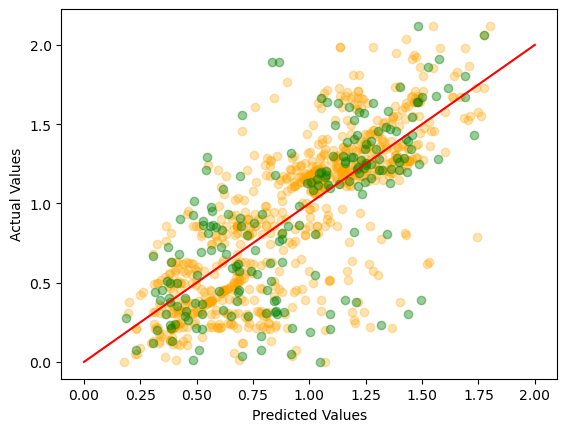

In [35]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 2.0], [0, 2.0], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [36]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-30 16:50:48,006] A new study created in memory with name: svm_parameter_opt
[I 2023-08-30 16:50:48,018] Trial 0 finished with value: -0.2121306234645751 and parameters: {'C': 68.016965959061, 'epsilon': 0.6742775567196091, 'kernel': 'linear', 'degree': 3}. Best is trial 0 with value: -0.2121306234645751.
[I 2023-08-30 16:50:48,193] Trial 1 finished with value: -2.3074764916710064 and parameters: {'C': 0.17926798321643383, 'epsilon': 0.02703975868620011, 'kernel': 'poly', 'degree': 4}. Best is trial 0 with value: -0.2121306234645751.
[I 2023-08-30 16:50:48,204] Trial 2 finished with value: -0.2121306234645751 and parameters: {'C': 6.395667307936559, 'epsilon': 0.3692679144524224, 'kernel': 'poly', 'degree': 2}. Best is trial 0 with value: -0.2121306234645751.
[I 2023-08-30 16:50:48,214] Trial 3 finished with value: -0.2121306234645751 and parameters: {'C': 4.206575042543194, 'epsilon': 0.3034741422478118, 'kernel': 'rbf', 'degree': 5}. Best is trial 0 with value: -0.212130623

Best r2:  0.48029854005889333
Best trial: {'C': 0.5673628029187258, 'epsilon': 0.03377746042299544, 'kernel': 'rbf', 'degree': 3}


In [37]:
optuna.visualization.plot_parallel_coordinate(study)

In [38]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 0.5673628029187258, 'epsilon': 0.03377746042299544, 'kernel': 'rbf', 'degree': 3}


In [39]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Cd_X_train, Cd_y_train)

SVR(C=0.5673628029187258, epsilon=0.03377746042299544)

In [40]:
y_train_pred = svm.predict(Cd_X_train)
y_test_pred = svm.predict(Cd_X_test)

In [41]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.04878139561835716
Test RMSE:  0.05545454583358325


In [42]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.680696455533765
Test R2:  0.573430035303507


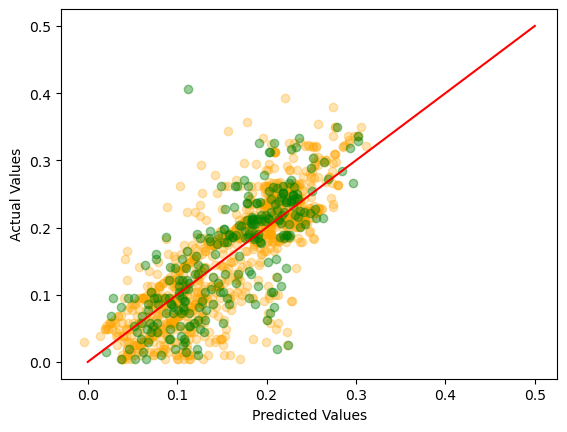

In [43]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

Ni

In [44]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-30 16:51:25,632] A new study created in memory with name: svm_parameter_opt
[I 2023-08-30 16:51:25,818] Trial 0 finished with value: 0.5524060030538547 and parameters: {'C': 0.16703854817887764, 'epsilon': 0.02556018062028628, 'kernel': 'rbf', 'degree': 5}. Best is trial 0 with value: 0.5524060030538547.
[I 2023-08-30 16:51:25,936] Trial 1 finished with value: 0.3953404875672772 and parameters: {'C': 0.2680755159359281, 'epsilon': 0.06494022581641562, 'kernel': 'poly', 'degree': 1}. Best is trial 0 with value: 0.5524060030538547.
[I 2023-08-30 16:51:26,132] Trial 2 finished with value: 0.7131858829879818 and parameters: {'C': 7.1361257641660645, 'epsilon': 0.12508956469671723, 'kernel': 'rbf', 'degree': 1}. Best is trial 2 with value: 0.7131858829879818.
[I 2023-08-30 16:51:26,365] Trial 3 finished with value: -16.615090139802522 and parameters: {'C': 25.92747959811974, 'epsilon': 0.2795578704098425, 'kernel': 'poly', 'degree': 5}. Best is trial 2 with value: 0.7131858829879

Best r2:  0.7161663532758171
Best trial: {'C': 21.635613671415687, 'epsilon': 0.40805061587752317, 'kernel': 'rbf', 'degree': 5}


In [45]:
optuna.visualization.plot_parallel_coordinate(study)

In [46]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 21.635613671415687, 'epsilon': 0.40805061587752317, 'kernel': 'rbf', 'degree': 5}


In [47]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Ni_X_train, Ni_y_train)

SVR(C=21.635613671415687, degree=5, epsilon=0.40805061587752317)

In [48]:
y_train_pred = svm.predict(Ni_X_train)
y_test_pred = svm.predict(Ni_X_test)

In [49]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.412589535600197
Test RMSE:  0.5446742738362328


In [50]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.8855596303886814
Test R2:  0.7752904153024178


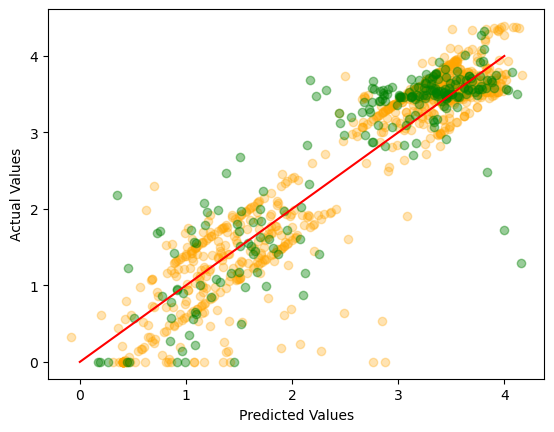

In [51]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()